# Tutorial 4: Naive Bayes 

In lecture we learned... what do we do when the likelihood is no longer tractable?

One option is to enforce simplifying assumptions to preserve the tractability of the likelihood, with an alg called Naive Bayes.

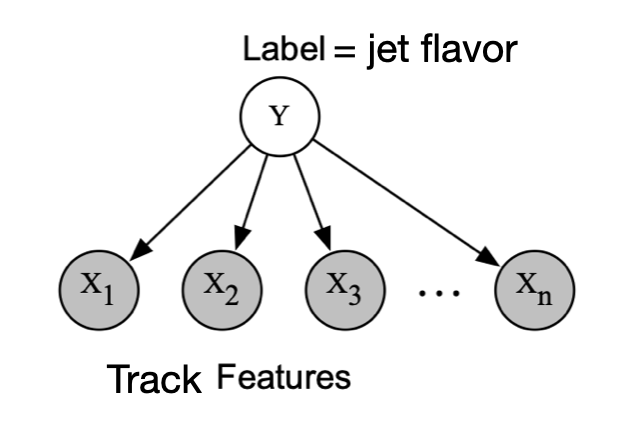

In [2]:
import numpy as np
import matplotlib.pyplot as plt

**Physics application:** $b$-tagging

$b$-hadrons have a characteristically ``long'' lifetime of $10^{-12}$ s, which we can observe by a measureable $\mathcal{O}$(mm) displacement from the main proton constitudent collision point, at the **primary vertex**.

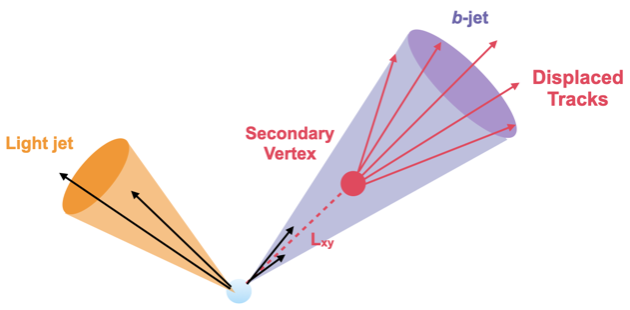

The variables we use to characterize this displacement of the track is this displacement, projected in the planes transervse to the proton flight path ($d_0$) and parallel to the flight path $z_0 \sin \theta$.

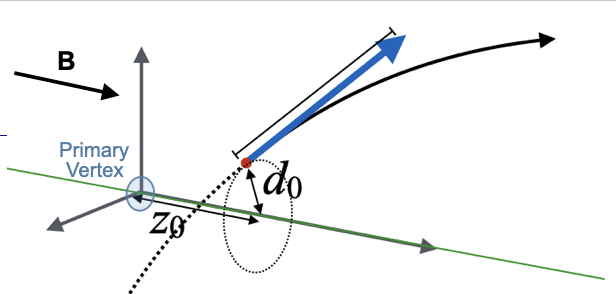

In [3]:
# !pip install uproot


In [4]:
# pcle phys specific packages -- natively handle variable length ``events''
# w/o applying masking
import uproot
import awkward as ak

**Soln:** Open Jonathan's dataset and save a slimmed version for the tutorial

In [61]:
cols = [f"trk_{v}" for v in ["d0", "z0", "d0err", "z0err"]]
cols += ["jet_flav"]

In [63]:
'''
Aside, how I saved the zonodo dataset for the students
'''

# f = uproot.open('valid_data.root')

# t = f["tree"]

# arr = t.arrays(cols)

# branches = {col: arr[col] for col in cols}

# # Create a new ROOT file and TTree
# with uproot.recreate("example.root") as fout:
#     fout["tree"] = branches


'\nAside, how I saved the zonodo dataset for the students\n'

In [64]:
t = uproot.open("example.root:tree")
arr = t.arrays(cols)

In [65]:
# The labels of the jet
y = arr['jet_flav']

In [66]:
np.unique(y)

<Array [0, 4, 5] type='3 * float32'>

^^ What do these labels mean?
- y= 5: $b$-jet (our signal)
- y=0: light-jet (our background)
- y=4: $c$-jet  (ignore for this problem)

**Features for Naive Bayes:**

$$X_i = \begin{pmatrix} 
s_{d0} \\
s_{z0}
\end{pmatrix}$$

where $s_{d0} = d_0 / \sigma_{z0}$, $s_{z0} = d_0 / \sigma_{z0}$

In [ ]:

sd0 = arr["trk_d0"] / arr["trk_d0err"]
sz0 = arr["trk_z0"] / arr["trk_z0err"]

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_45095/4184772354.py:32: SyntaxWarning: invalid escape sequence '\s'
  ax[0].set_xlabel("$sd0 = d_{0} / \sigma(d_{0})$", fontsize=14)
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_45095/4184772354.py:33: SyntaxWarning: invalid escape sequence '\s'
  ax[1].set_xlabel("$sz0 = z_{0} / \sigma(z_{0})$", fontsize=14)


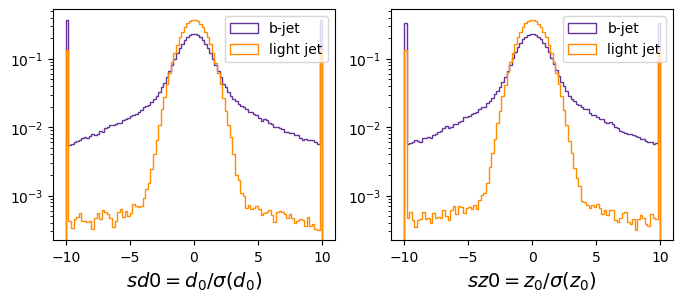

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

clip = (-10, 10)
kwargs = dict(bins=100, histtype="step", density=True, log=True)

ax[0].hist(
    np.clip(ak.flatten(sd0[y == 5]), *clip),
    color="rebeccapurple",
    label="b-jet",
    **kwargs,
)
ax[0].hist(
    np.clip(ak.flatten(sd0[y == 0]), *clip),
    color="darkorange",
    label="light jet",
    **kwargs,
)

"""
Q1: Also plot the 1d z0 dist

"""

ax[1].hist(
    np.clip(ak.flatten(sz0[y == 5]), *clip),
    color="rebeccapurple",
    label="b-jet",
    **kwargs,
)
ax[1].hist(
    np.clip(ak.flatten(sz0[y == 0]), *clip),
    color="darkorange",
    label="light jet",
    **kwargs,
)

ax[0].set_xlabel("$sd0 = d_{0} / \sigma(d_{0})$", fontsize=14)
ax[1].set_xlabel("$sz0 = z_{0} / \sigma(z_{0})$", fontsize=14)

ax[0].legend()
ax[1].legend()

plt.show()


In [71]:
'''
Q2: To build up the conditional probabilities, we actually want to look at 
the 2d histograms, you're challenge, define these $p(X_i |)$

'''

"\nQ2: To build up the conditional probabilities, we actually want to look at \nthe 2d histograms, you're challenge, define these $p(X_i | Y)$\n\n"

In [13]:
import matplotlib.colors as colors

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_45095/3822532201.py:5: MatplotlibDeprecationWarning: Passing the range parameter of hist2d() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  p_b, ex, ey, _ = ax[0].hist2d(
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_45095/3822532201.py:14: MatplotlibDeprecationWarning: Passing the range parameter of hist2d() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  p_l, *_ = ax[1].hist2d(


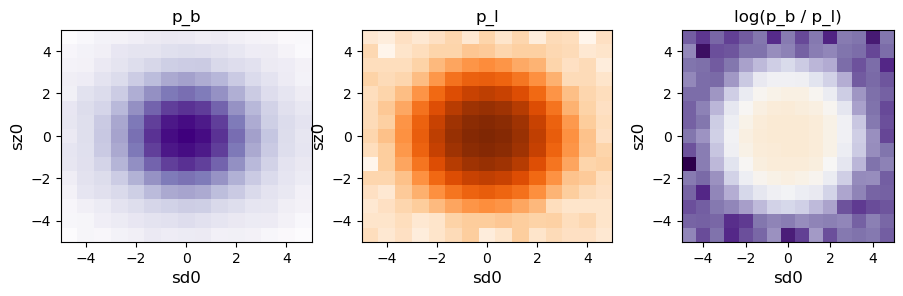

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(11, 2.75))

clip = (-5,5)
nbins = 15
p_b, ex, ey, _ = ax[0].hist2d(
    np.clip(ak.flatten(sd0[y == 5])).to_numpy(),
    np.clip(ak.flatten(sz0[y == 5])).to_numpy(),
    nbins,
    [clip, clip],
    cmap="Purples",
    norm=colors.LogNorm(),
)

p_l, *_ = ax[1].hist2d(
    np.clip(ak.flatten(sd0[y == 0])).to_numpy(),
    np.clip(ak.flatten(sz0[y == 0])).to_numpy(),
    nbins,
    [clip, clip],
    cmap="Oranges",
    norm=colors.LogNorm(),
)


# Then use the p_b and p_l histos to define the negative log likelihood ratio
# (provided)
llr = np.log(p_b) - np.log(p_l) # log likelihood ratio

vscale = np.max(abs(llr))

cbar = ax[2].imshow(
    llr.T,
    origin="lower",
    vmin=-vscale, 
    vmax=vscale,
    extent=[*clip, *clip],
    cmap="PuOr",  
)
# fig.colorbar(cbar, ax = ax[2],shrink=.7)

ax[0].set_title('p_b')
ax[1].set_title("p_l")
ax[2].set_title("log(p_b / p_l)")

for axi in ax:
    axi.set_xlabel("sd0", fontsize=12)
    axi.set_ylabel("sz0",fontsize=12)

# p_l = plt.hist2d()

In [73]:
''' 
Code snippet below: define the indices for the bin 
an (sd0, sz0) track is in
'''

i0 = np.digitize(
    np.clip(ak.flatten(sd0), *clip).to_numpy(),
    bins=ex,
)-1
i1 = np.digitize(
    np.clip(ak.flatten(sz0), *clip).to_numpy(),
    bins=ey,
)-1

print('min',min(i0), min(i1))
print("max", max(i0), max(i1))

i0 = ak.where(i0==nbins,nbins-1,i0)
i1 = ak.where(i1 == nbins, nbins - 1, i1)

min 0 0
max 15 15


In [48]:
# number of tracks passing a cut value
nTrks = ak.count(sd0,axis=1)
print(nTrks)

[2, 5, 3, 7, 2, 5, 9, 2, 12, 2, 6, 8, ..., 14, 10, 4, 5, 5, 13, 11, 8, 7, 3, 10]


/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_45095/507567961.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Entries')

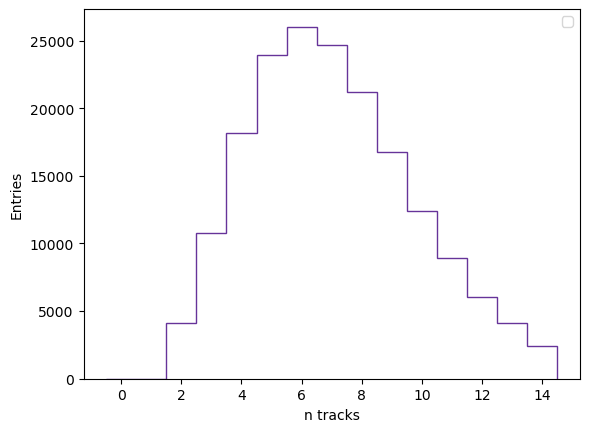

In [54]:
kwargs = dict(bins=15, range=(-0.5, 14.5), histtype="step")
plt.hist(nTrks,color='rebeccapurple',**kwargs)
plt.legend()
plt.xlabel('n tracks')
plt.ylabel("Entries")

In [36]:
# log likelihood ratio calculated for each track
llr_trk_i = ak.unflatten(llr[i0,i1],nTrks)


In [ ]:
'''
Q3: Your task, find the log likelihood for each jet
'''

llr_jet = ak.sum(llr_trk_i, axis=1)

In [56]:
# Plot the distribtuion of llr_jet
# for the b and light jets

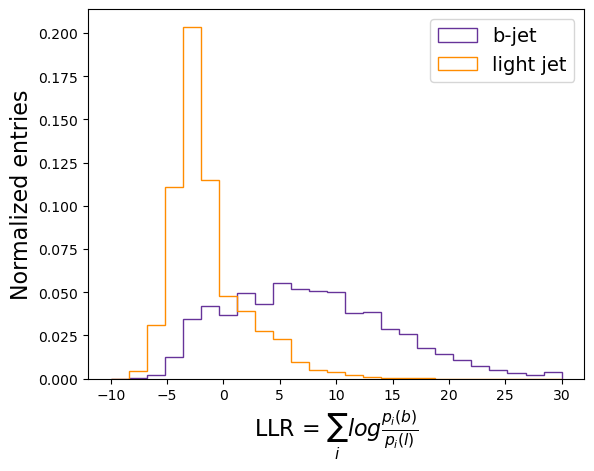

In [ ]:
"""
Q4: Plot the distribtuion of llr_jet for the b and light jets
"""

r = (-10,30)
kwargs = dict(bins=25,range=r,histtype='step',density=True)

b_hist, e,_ = plt.hist(np.clip(llr_jet[y==5],*r),label='b-jet',color='rebeccapurple',**kwargs)
l_hist, *_  = plt.hist(np.clip(llr_jet[y == 0], *r), label="light jet", color="darkorange", **kwargs)

plt.xlabel(r'LLR = $\sum_i log \frac{p_i(b) }{ p_i(l) }$',fontsize=16)
plt.ylabel("Normalized entries", fontsize=16)
plt.legend(fontsize=14)

Text(0.5, 0, 'False positive rate')

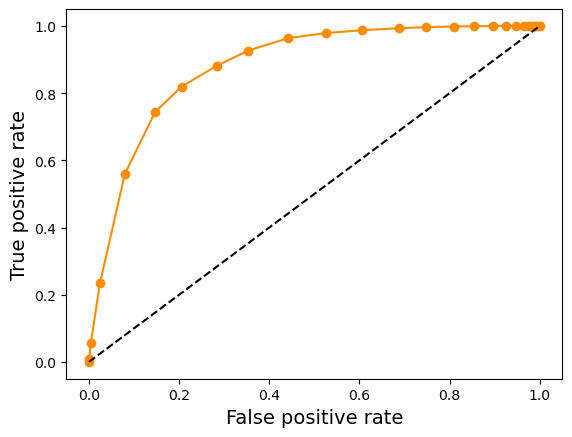

In [ ]:
# Q5: Plot the ROC curve
# y-axis: true positive rate
# x-axis: false positive rate

# How did the Naive Bayes alg do? Is it working??

true_pos = np.add.accumulate(b_hist)/np.sum(b_hist)
false_pos = np.add.accumulate(l_hist) / np.sum(l_hist)

plt.plot(true_pos, false_pos, color='darkorange', marker='o')

plt.plot([0,1],[0,1],'k--')

plt.ylabel("True positive rate", fontsize=14)
plt.xlabel("False positive rate",fontsize=14)

In [40]:
true_pos #.shape * np.diff(false_pos).shape

array([0.00000000e+00, 5.15549642e-04, 4.19091967e-03, 2.43638783e-02,
       7.97272576e-02, 1.46648927e-01, 2.05654415e-01, 2.84566772e-01,
       3.53617163e-01, 4.41842674e-01, 5.25128887e-01, 6.06186596e-01,
       6.86545817e-01, 7.47380675e-01, 8.09096957e-01, 8.54814568e-01,
       8.95759188e-01, 9.24563446e-01, 9.46998171e-01, 9.63994678e-01,
       9.76135041e-01, 9.84084484e-01, 9.89738899e-01, 9.93464161e-01,
       1.00000000e+00])

In [ ]:
false_pos

array([3.30764397e-05, 8.66602719e-03, 7.35620018e-02, 3.07329739e-01,
       7.30410479e-01, 9.49260742e-01, 9.79211458e-01, 9.91697814e-01,
       9.96096980e-01, 9.98048490e-01, 9.98858863e-01, 9.99338471e-01,
       9.99751927e-01, 9.99867694e-01, 9.99884232e-01, 9.99950385e-01,
       9.99950385e-01, 9.99983462e-01, 9.99983462e-01, 9.99983462e-01,
       9.99983462e-01, 9.99983462e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00])

In [ ]:
np.diff(false_pos)


np.float64(0.9999669235603478)

In [92]:
np.sum(np.add.accumulate(true_pos[1:]) * np.diff(false_pos))

np.float64(0.23183213925259072)

In [ ]:
true_pos[1:]

array([5.98702811e-04, 6.30301014e-03, 3.66372859e-02, 1.24879428e-01,
       2.51039415e-01, 3.36371196e-01, 4.48162315e-01, 5.42607683e-01,
       6.33045069e-01, 7.23881590e-01, 7.86479295e-01, 8.50889739e-01,
       8.91318809e-01, 9.25810743e-01, 9.50656910e-01, 9.68185598e-01,
       9.80026609e-01, 9.87344088e-01, 9.92117080e-01, 9.95227008e-01,
       9.97339099e-01, 9.98303675e-01, 9.98968901e-01, 1.00000000e+00])

In [80]:
np.diff(false_pos).shape

(24,)